# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning 

This kind of problem is known as a **regression problem**.

The data and evaluation metric we'll be using (root mean square log error or RMSLE) is from the [Kaggle Bluebook for Bulldozers competition](https://www.kaggle.com/c/bluebook-for-bulldozers/overview).

We'll work through each step and by the end of the notebook, we'll have a trained machine learning model which predicts the sale price of a bulldozer given different characteristics about it.

## Problem Definition

For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## Data

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you can you it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

## Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

## Features

Features are different parts of the data. During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this, is to create a **data dictionary**.

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means. You can [download this file directly from the Kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) (account required) or view it on Google Sheets.

With all of this being known, let's get started! 

First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from matplotlib.patches import Patch
sns.set_theme(style="darkgrid")

## Data Exploration and Feature Engineering

In [2]:
df = pd.read_csv("bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [5]:
df["saledate"][:100]

0     11/16/2006 0:00
1      3/26/2004 0:00
2      2/26/2004 0:00
3      5/19/2011 0:00
4      7/23/2009 0:00
           ...       
95    12/15/2005 0:00
96     1/29/2004 0:00
97     9/18/2008 0:00
98     11/3/2005 0:00
99      6/1/2006 0:00
Name: saledate, Length: 100, dtype: object

In [6]:
df.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter
count,4.126980e+05,412698.000000,4.126980e+05,412698.000000,412698.000000,392562.000000,412698.000000,1.475040e+05
mean,2.011161e+06,31215.181414,1.230061e+06,6947.201828,135.169361,6.585268,1899.049637,3.522988e+03
std,1.080068e+06,23141.743695,4.539533e+05,6280.824982,9.646749,17.158409,292.190243,2.716993e+04
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00
25%,1.421898e+06,14500.000000,1.088593e+06,3261.000000,132.000000,1.000000,1985.000000,0.000000e+00
50%,1.645852e+06,24000.000000,1.284397e+06,4605.000000,132.000000,2.000000,1995.000000,0.000000e+00
75%,2.261012e+06,40000.000000,1.478079e+06,8899.000000,136.000000,4.000000,2001.000000,3.209000e+03
max,6.333349e+06,142000.000000,2.486330e+06,37198.000000,173.000000,99.000000,2014.000000,2.483300e+06


In [7]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='SalePrice', ylabel='Count'>

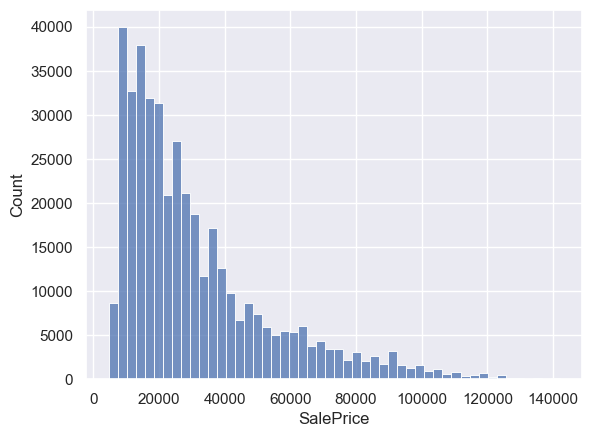

In [8]:
sns.histplot(x=df["SalePrice"], bins=50)

<Axes: xlabel='YearMade', ylabel='Count'>

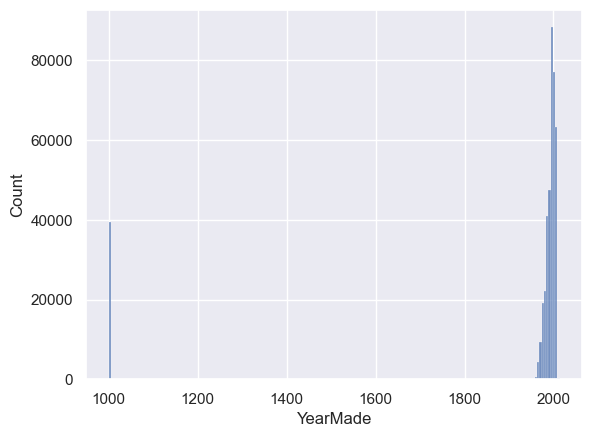

In [9]:
sns.histplot(x=df["YearMade"], bins=200)

<Axes: xlabel='YearMade', ylabel='Count'>

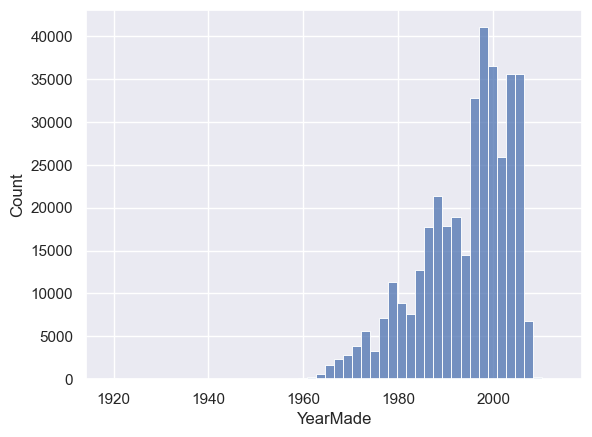

In [10]:
sns.histplot(x=df[df["YearMade"] != 1000].YearMade, bins=50)

<Axes: xlabel='YearMade', ylabel='SalePrice'>

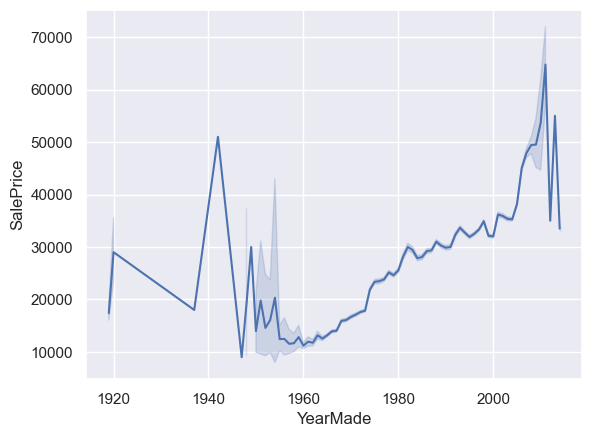

In [11]:
sns.lineplot(data=df, x=df[df["YearMade"] != 1000].YearMade, y=df["SalePrice"])

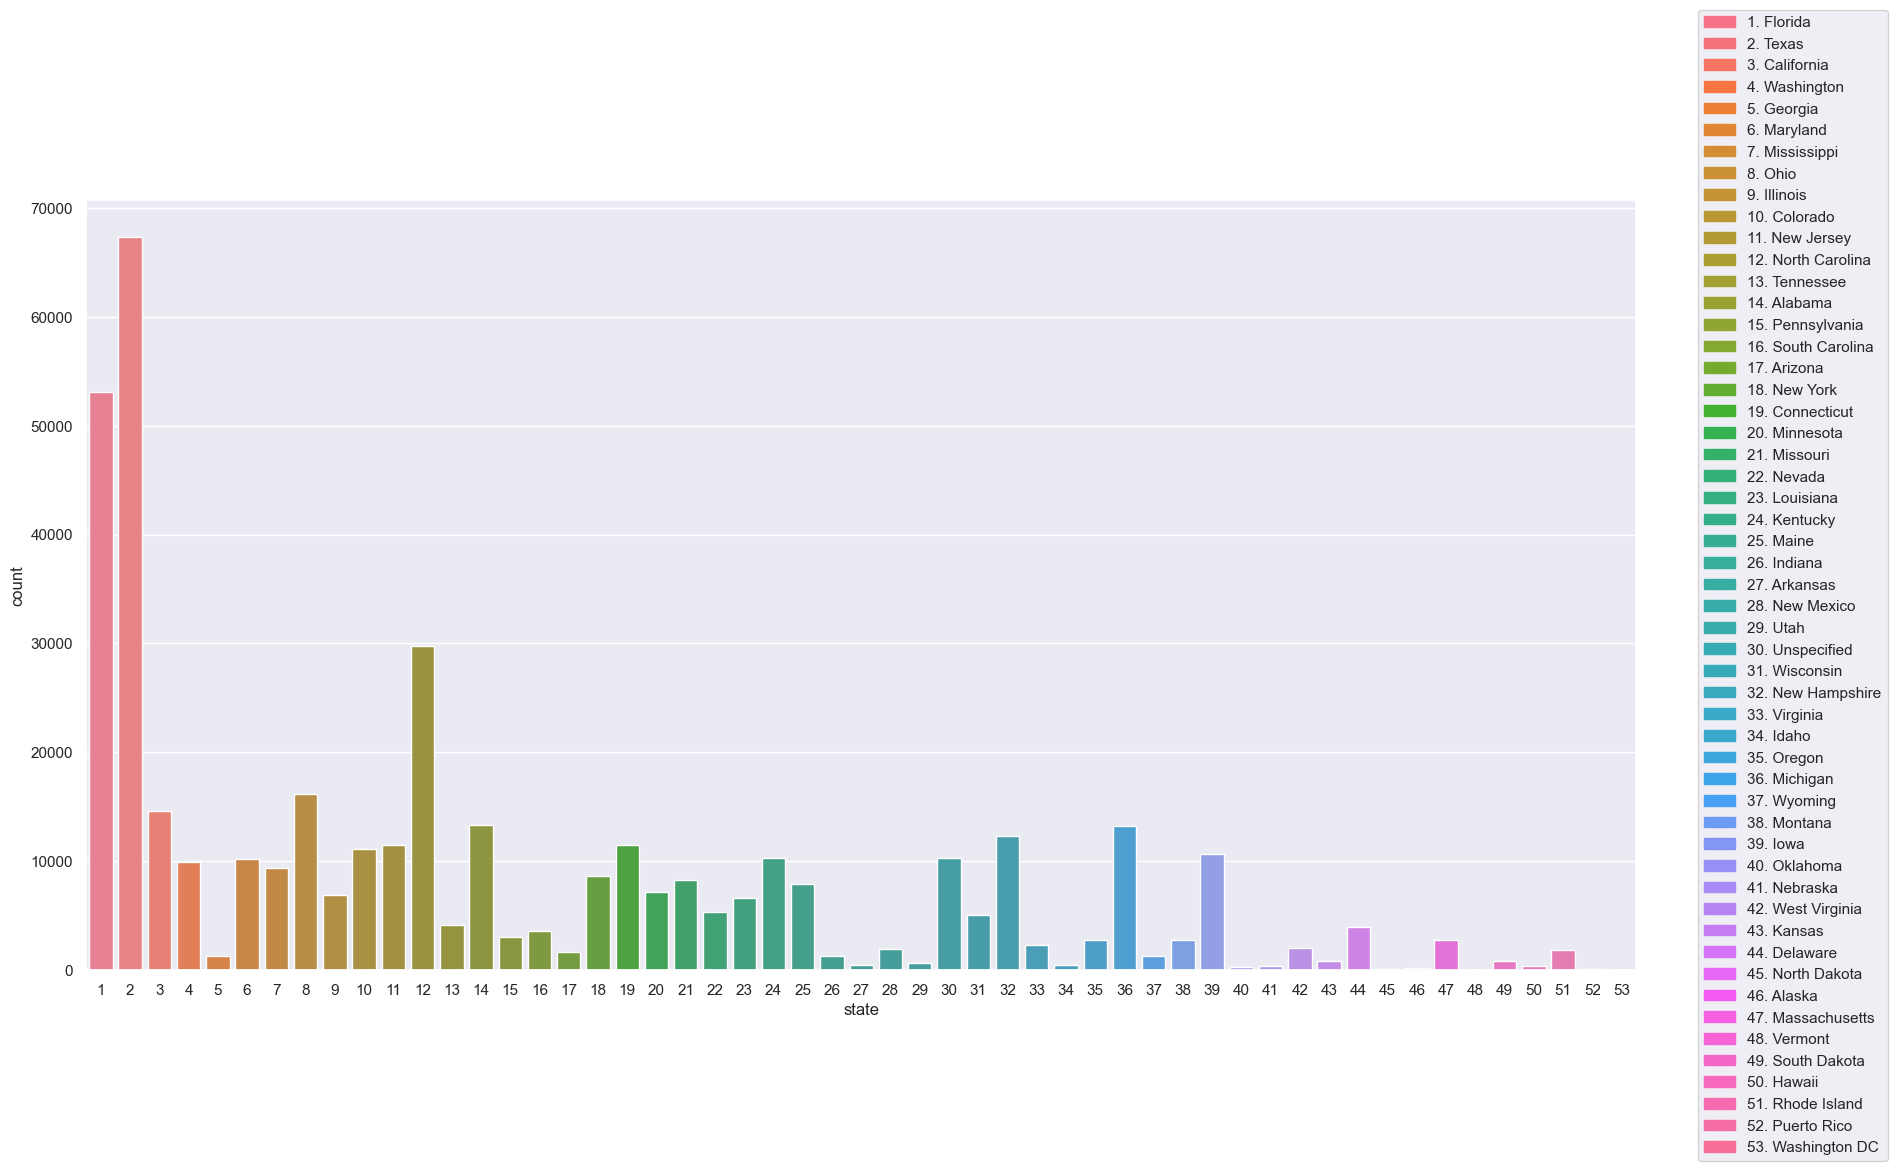

In [32]:
plt.rcParams["figure.figsize"] = (20,10)

# create a color palette the length of the amount of categories in 'state'
colors = sns.color_palette('husl', n_colors=53)

# plot
p = sns.countplot(data=df, x='state', palette=colors)
plt.gca().set_xticklabels([i for i in range(1, 54)])

#enumarate the states
states=df["state"].value_counts().index
labels = list([str(i + 1)+ ". " + state for i, state in enumerate(states)])

# create color map
cmap = dict(zip(labels, colors))

# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmap.items()]

# add the legend
plt.legend(handles=patches, bbox_to_anchor=(1.04, 0.5), loc='center left', borderaxespad=0)

In [33]:
df["state"].value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

### Parsing dates

In [13]:
df["saledate"] = pd.to_datetime(df["saledate"])

In [14]:
df["saledate"].dtype

dtype('<M8[ns]')

In [15]:
df["saledate"].head(10)

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
5   2008-12-18
6   2004-08-26
7   2005-11-17
8   2009-08-27
9   2007-08-09
Name: saledate, dtype: datetime64[ns]

<Axes: xlabel='saledate', ylabel='Count'>

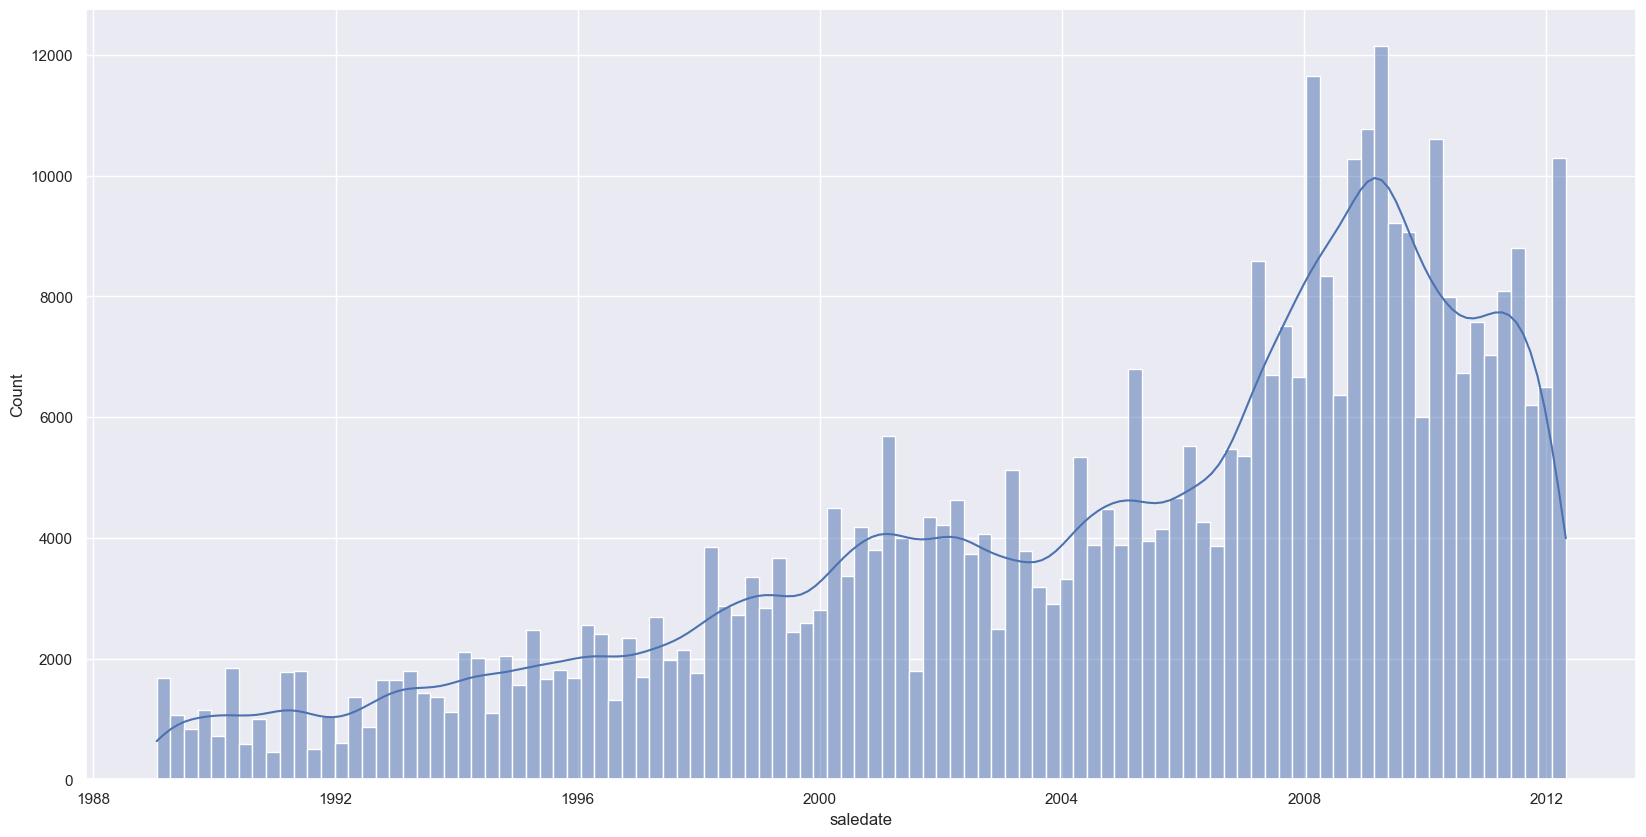

In [16]:
sns.histplot(x=df["saledate"], kde=True)

<Axes: xlabel='saledate', ylabel='SalePrice'>

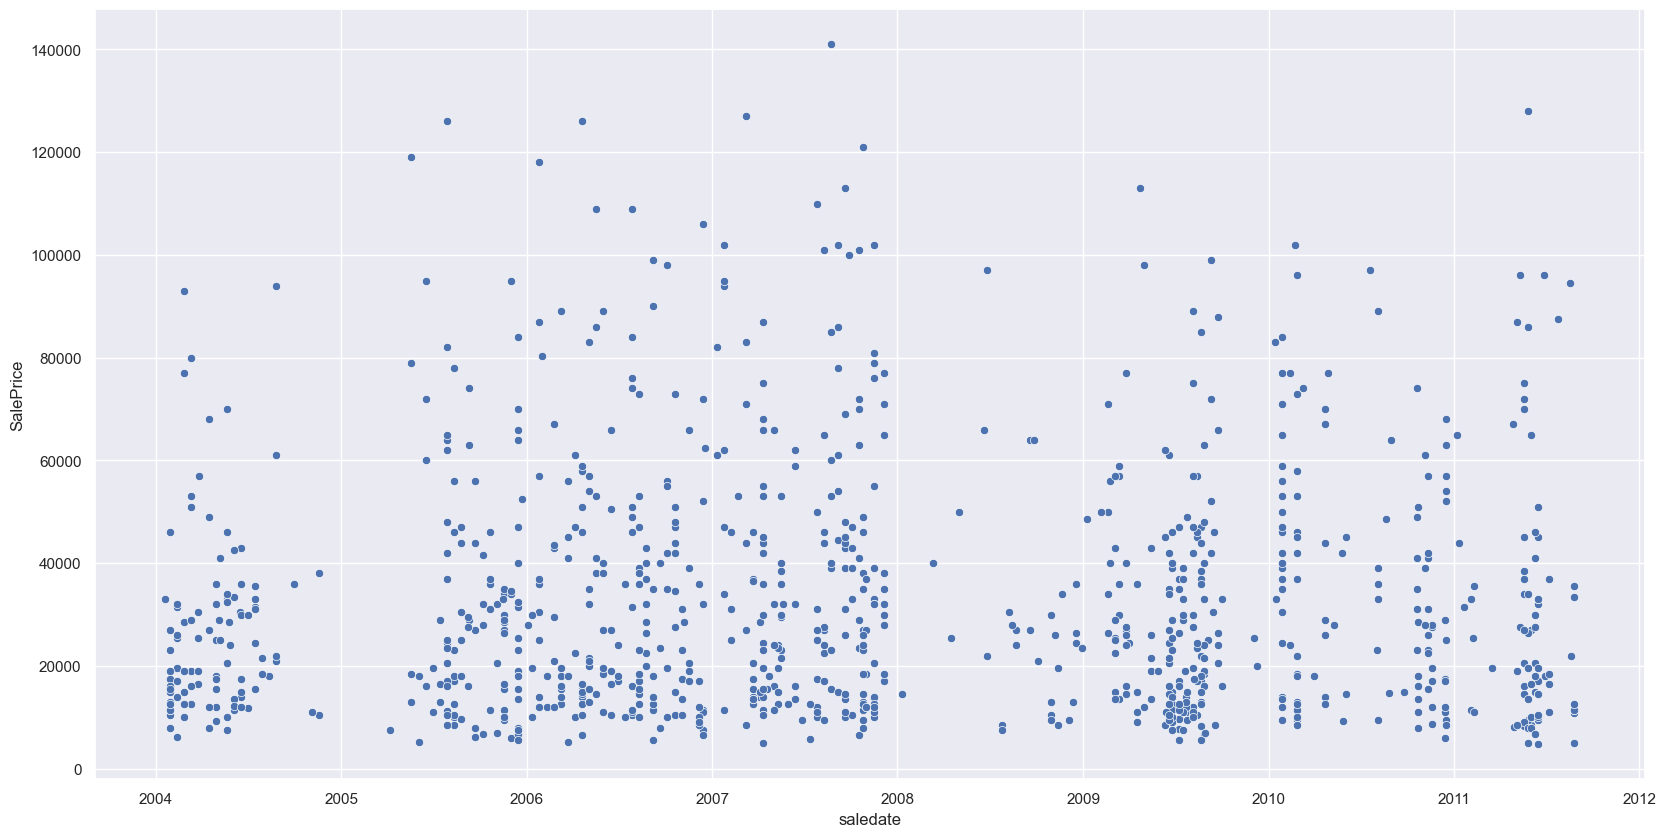

In [17]:
sns.scatterplot(x=df["saledate"][:1000], y=df["SalePrice"][:1000])

In [18]:
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df["saledate"].head(10)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
Name: saledate, dtype: datetime64[ns]

Making copy of the original DataFrame

In [19]:
df_tmp = df.copy()

In [20]:
# Add datetime parameters for saledate
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayofweek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayofyear"] = df_tmp.saledate.dt.dayofyear

# Drop original saledate
df_tmp.drop("saledate", axis=1, inplace=True)

### Converting objects to categories

In [22]:
df_tmp.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleDay', 'saleDayofweek', 'saleDayofyear'],
      dtype

In [23]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [25]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [26]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

### Handle missings

In [27]:
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

#### Numerical values

In [36]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayofweek
saleDayofyear


In [38]:
#Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [43]:
#Fill numeric rows with the median
#Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            #Add a binary column which tells us if the data was missing 
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            #Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

In [44]:
#Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

#### Categorical values

In [45]:
#Check for which categorical columns have null values
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [46]:
#Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        #Add a binary column which tells us if the data was missing 
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        df_tmp[label] = pd.Categorical(content).codes+1

In [47]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

In [52]:
for label,content in df_tmp.items():
    if "_is_missing" in label:
        df_tmp[label] = df_tmp[label].astype(int)

In [53]:
df_tmp.auctioneerID_is_missing

205615    0
274835    0
141296    0
212552    0
62755     0
         ..
410879    0
412476    0
411927    0
407124    0
409203    0
Name: auctioneerID_is_missing, Length: 412698, dtype: int32

## Modeling

In [56]:
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [57]:
#Spliting the data
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val["SalePrice"]

In [59]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [58]:
y_train

205615     9500.0
274835    14000.0
141296    50000.0
212552    16000.0
62755     22000.0
           ...   
393098    29000.0
400217    11000.0
400302    11000.0
400393    18000.0
393123    13500.0
Name: SalePrice, Length: 401125, dtype: float64

### Building evaluation function

In [60]:
def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

### Testing our model on a subset(to tune the hyperparametres)

In [62]:
model = RandomForestRegressor(n_jobs=-1, 
                              random_state=42, 
                              max_samples=10000)

In [63]:
%%time

model.fit(X_train, y_train)

CPU times: total: 1min 37s
Wall time: 13.8 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [66]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

### Hyperparameter tuning with RandomizedSearchCV

In [99]:
%%time

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1.0, "sqrt"]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=100,
                              cv=5,
                              n_jobs=-1,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 10min 37s
Wall time: 5h 51min 8s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1.0, 'sqrt'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [100]:
show_scores(rs_model)

{'Training MAE': 2580.45501218304,
 'Valid MAE': 5928.5033993009565,
 'Training RMSLE': 0.12879862975716294,
 'Valid RMSLE': 0.24534357660844602,
 'Training R^2': 0.9682253263312878,
 'Valid R^2': 0.8831951337550882}

In [101]:
rs_model.best_params_

{'n_estimators': 80,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 0.5,
 'max_depth': None}

In [104]:
ideal_model = RandomForestRegressor(n_estimators=80,
                                    min_samples_leaf=1,
                                    min_samples_split=10,
                                    max_features=0.5,
                                    n_jobs=-1)
ideal_model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.5, min_samples_split=10, n_estimators=80,
                      n_jobs=-1)

In [105]:
show_scores(ideal_model)

{'Training MAE': 2578.371470513261,
 'Valid MAE': 5901.364537436171,
 'Training RMSLE': 0.12859082788082135,
 'Valid RMSLE': 0.24432257162395787,
 'Training R^2': 0.968261187086947,
 'Valid R^2': 0.8839936489211925}

## Make predictions on test data

In [106]:
df_test = pd.read_csv("bluebook-for-bulldozers/Test.csv",parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### Preprocessing the test data

In [107]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes+1
    
    # Replace True/False with 1/0
    for label,content in df.items():
        if "_is_missing" in label:
            df[label] = df[label].astype(int)
    
    return df

In [108]:
df_test = preprocess_data(df_test)
df_test.head().T

,0,1,2,3,4
SalesID,1227829.0,1227844.0,1227847.0,1227848.0,1227863.0
MachineID,1006309.0,1022817.0,1031560.0,56204.0,1053887.0
ModelID,3168.0,7271.0,22805.0,1269.0,22312.0
datasource,121.0,121.0,121.0,121.0,121.0
auctioneerID,3.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...
Backhoe_Mounting_is_missing,1.0,1.0,1.0,1.0,0.0
Blade_Type_is_missing,1.0,1.0,1.0,1.0,0.0
Travel_Controls_is_missing,1.0,1.0,1.0,1.0,0.0
Differential_Type_is_missing,1.0,0.0,1.0,1.0,1.0


In [109]:
len(X_train.columns), len(df_test.columns)

(102, 101)

Our test dataset (after preprocessing) has 101 columns where as, our training dataset (X_train) has 102 columns (after preprocessing). Let's find the difference.

In [110]:
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

This is because we don't have missing data on `auctioneerID` column in test dataset.

In [111]:
df_test["auctioneerID_is_missing"] = 0
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,1,1,1,1,1,1,1,1,1,0
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,1,1,1,1,1,1,1,0,0,0
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,0,0,0,0,1,1,1,1,1,0
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,0,0,0,0,1,1,1,1,1,0
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,1,1,1,1,0,0,0,1,1,0


In [112]:
# Match column order from X_train to df_test (to predict on columns, they should be in the same order they were fit on)
df_test = df_test[X_train.columns]

In [113]:
# Make predictions on the test dataset using the best model
test_preds = ideal_model.predict(df_test)

In [114]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,17216.403458
1,1227844,17823.867797
2,1227847,53195.196589
3,1227848,66074.427296
4,1227863,53448.574450
...,...,...
12452,6643171,43426.666216
12453,6643173,12694.714568
12454,6643184,14025.091151
12455,6643186,17307.167590


In [115]:
# Export to csv
df_preds.to_csv("bluebook-for-bulldozers/predictions.csv", index=False)

## Feature importnace

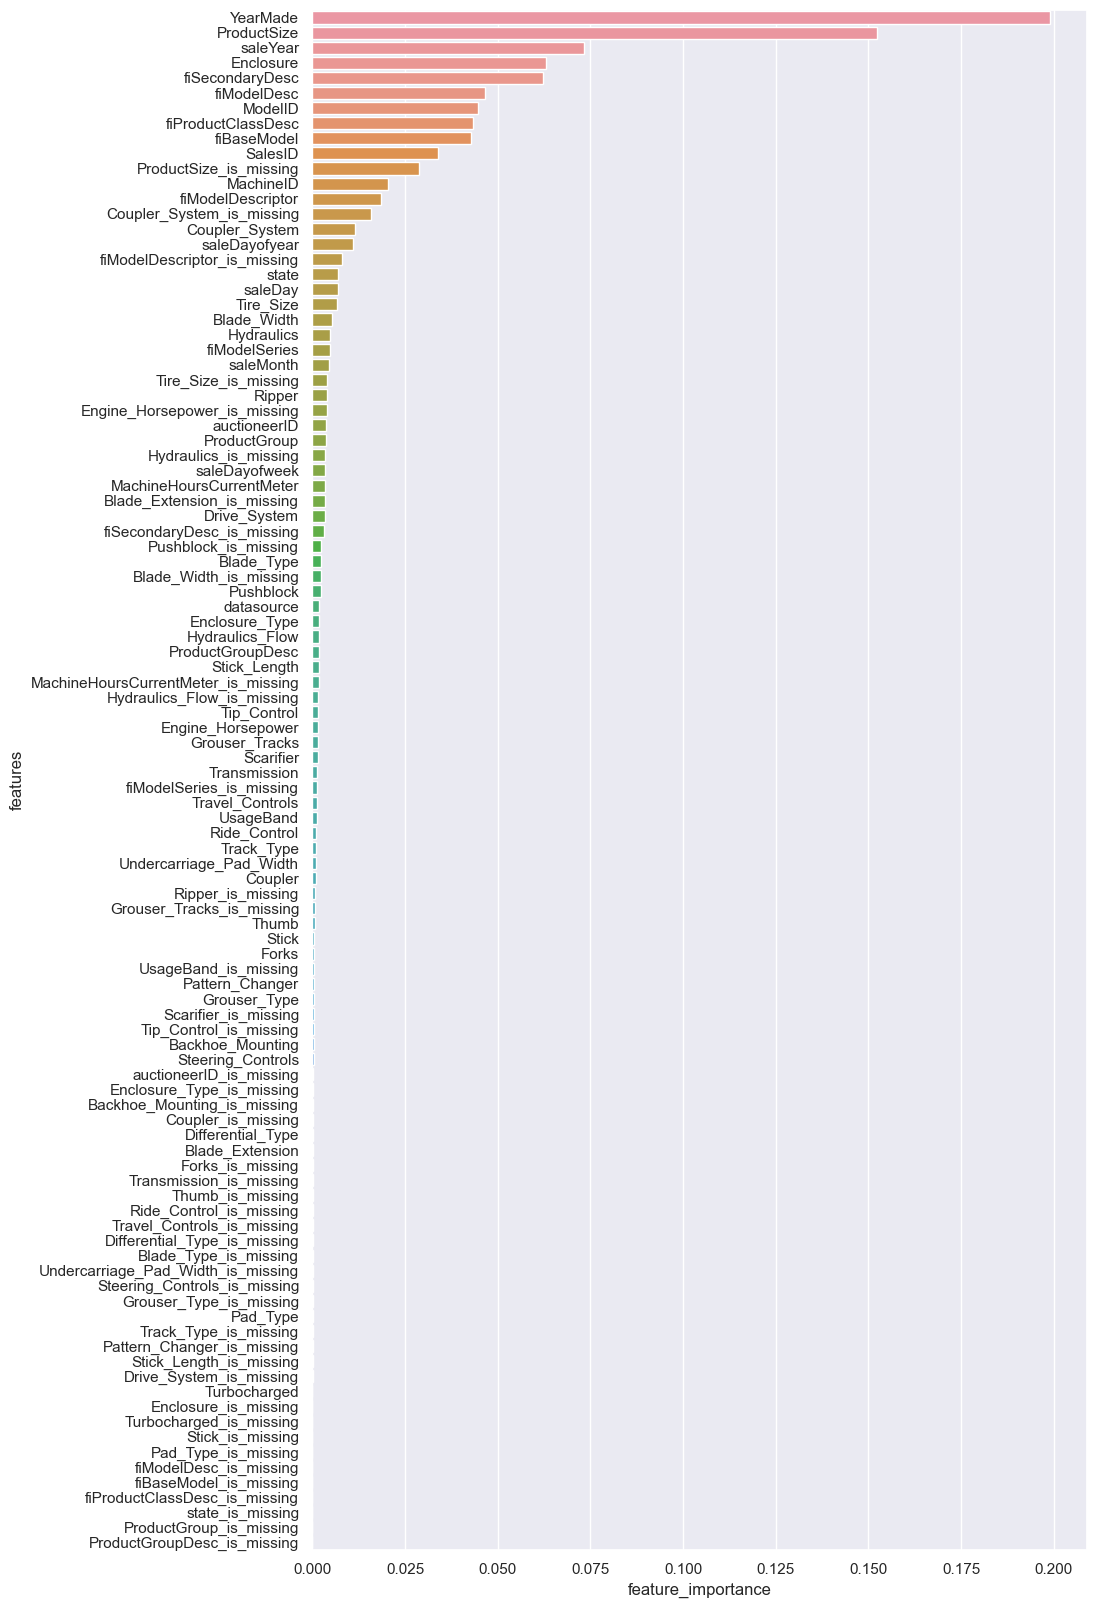

In [135]:
plt.rcParams['figure.figsize'] = (10, 20)
df = pd.DataFrame({"features": df_test.columns,
                   "feature_importance": ideal_model.feature_importances_})

df.sort_values("feature_importance", ascending=False, inplace=True)
  
sns.barplot(x="feature_importance", y="features",data=df, orient="h");

In [149]:
ideal_model.feature_importances_

array([3.38698925e-04, 2.04047743e-04, 4.45534465e-04, 1.91080450e-05,
       3.79202217e-05, 1.99116611e-03, 3.43445041e-05, 1.15718928e-05,
       4.64613290e-04, 4.27970112e-04, 6.22651843e-04, 4.64033903e-05,
       1.83848542e-04, 1.52399709e-03, 4.34303125e-04, 6.95690384e-05,
       3.75151928e-05, 1.71458655e-05, 3.30989739e-05, 6.31275037e-04,
       5.07590799e-06, 6.04190131e-07, 1.10158195e-05, 5.23324942e-06,
       1.37385971e-05, 3.07472351e-07, 1.90700287e-06, 5.37130207e-05,
       1.88198617e-05, 1.53030244e-05, 4.81266151e-05, 2.20803284e-05,
       3.98182658e-05, 1.39052583e-05, 1.55200409e-05, 6.67299874e-05,
       9.27159010e-06, 1.14849102e-04, 1.50240397e-05, 1.87345796e-05,
       1.06237854e-05, 9.43874610e-06, 1.71378903e-05, 6.21985977e-06,
       4.28718239e-06, 4.19142813e-06, 3.32091546e-06, 2.25137464e-05,
       1.26111777e-05, 2.28830951e-06, 3.07280968e-06, 7.31477093e-04,
       4.39880397e-05, 6.85813172e-05, 3.48128573e-05, 1.10042811e-04,
      